<a href="https://colab.research.google.com/github/NID123-CH/DSR-40/blob/main/DSR_40_LGBM(Obesity_Risk).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (4).json


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
!kaggle datasets download -d maseratiurm/multi-class-prediction-of-obesity-risk

Dataset URL: https://www.kaggle.com/datasets/maseratiurm/multi-class-prediction-of-obesity-risk
License(s): apache-2.0
multi-class-prediction-of-obesity-risk.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/multi-class-prediction-of-obesity-risk.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
def create_csv_file(x,y):
    df=pd.DataFrame({'id':x, 'NObeyesdad':y})
    df.to_csv('submission.csv', index=False)

In [7]:
df_test=pd.read_csv('/content/test.csv/test.csv',index_col='id')
df_train=pd.read_csv('/content/train.csv/train.csv',index_col='id')
original_data = pd.read_csv('/content/ObesityDataSet.csv')

In [8]:
# Size of each dataset
print(df_test.shape)
print(df_train.shape)
print(original_data.shape)

(13840, 16)
(20758, 17)
(2111, 17)


In [9]:
df_train.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


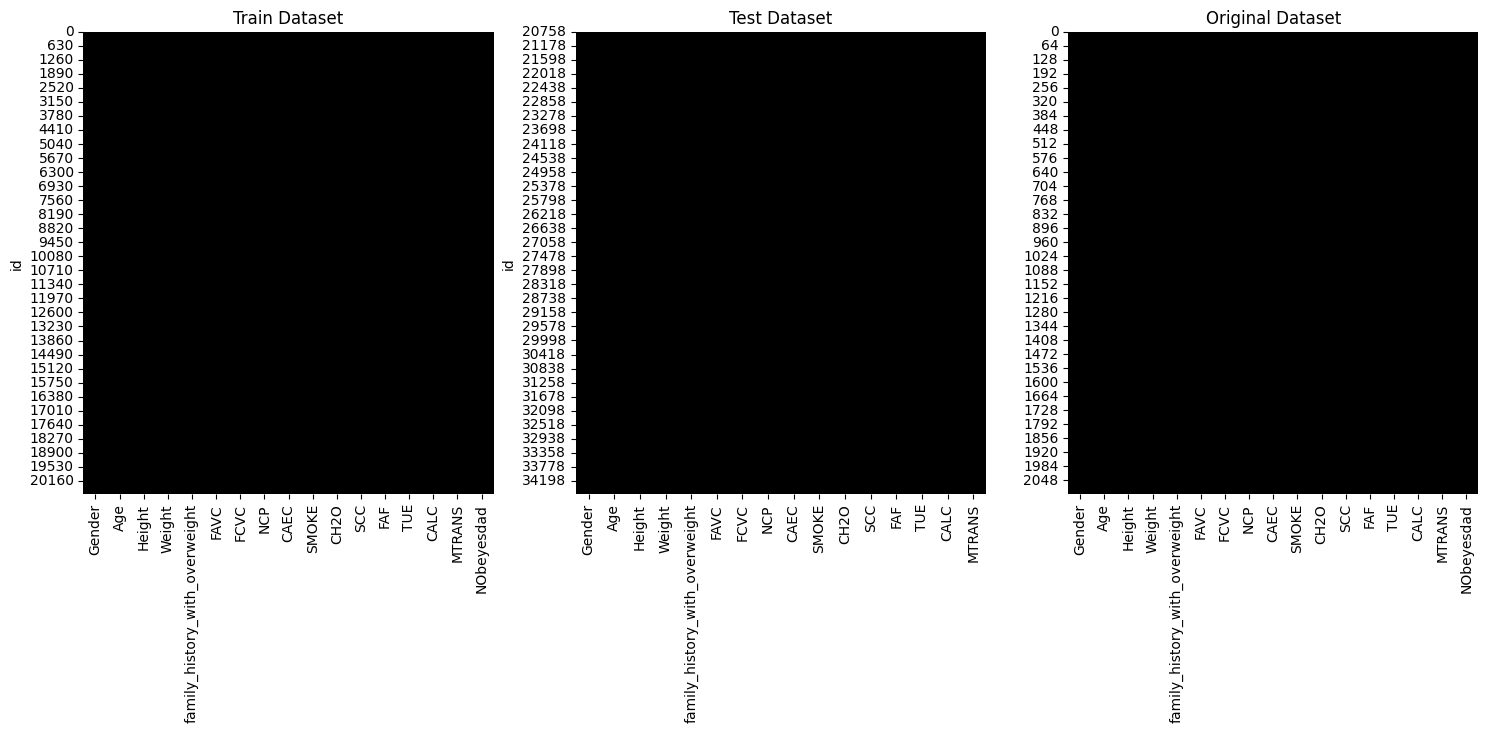

In [10]:
# Visualize Null values (GRAYYY)
# Create a subplot with dimensions (1, 3)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Visualize null values in train dataset
sns.heatmap(df_train.isna(), cmap='gray', cbar=False, ax=axes[0])
axes[0].set_title('Train Dataset')

# Visualize null values in test dataset
sns.heatmap(df_test.isna(), cmap='gray', cbar=False, ax=axes[1])
axes[1].set_title('Test Dataset')

# Visualize null values in original dataset
sns.heatmap(original_data.isna(), cmap='gray', cbar=False, ax=axes[2])
axes[2].set_title('Original Dataset')

plt.show()


In [11]:
def get_variable_types(dataframe):
    continuous_vars = []
    categorical_vars = []

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            categorical_vars.append(column)
        else:
            continuous_vars.append(column)

    return continuous_vars, categorical_vars

continuous_vars, categorical_vars = get_variable_types(df_train)
#continuous_vars.remove('id'),
# categorical_vars.remove('NObeyesdad')

print("Continuous Variables:", continuous_vars)
print("Categorical Variables:", categorical_vars)

Continuous Variables: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Variables: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']


In [12]:
# Plot a histogram of a column with the amount of column for each obesity result
def plot_histograms_and_density(dataframe, column):
    fig, ax = plt.subplots(figsize=(16, 4))
    fig = sns.histplot(data=dataframe, x=column, hue="NObeyesdad", bins=50, kde=True)
    plt.ylim(0,500)
    plt.show()

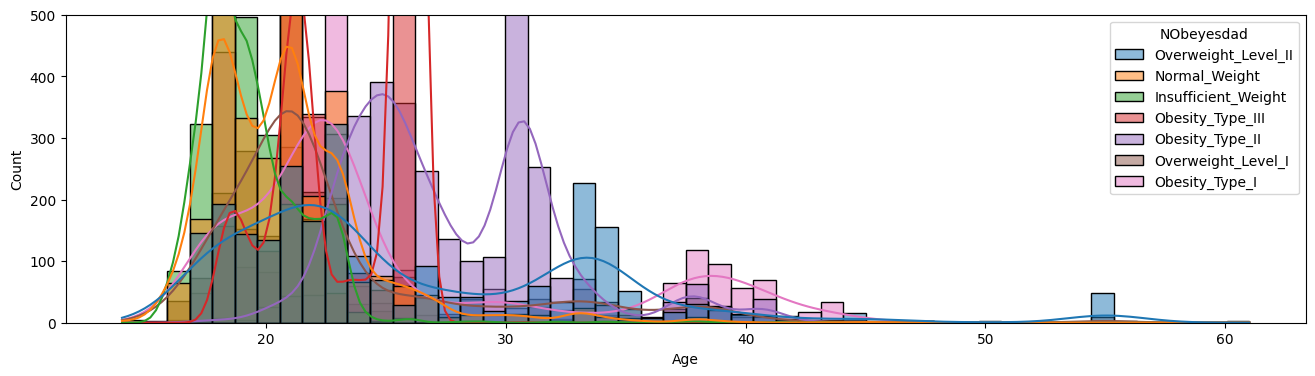

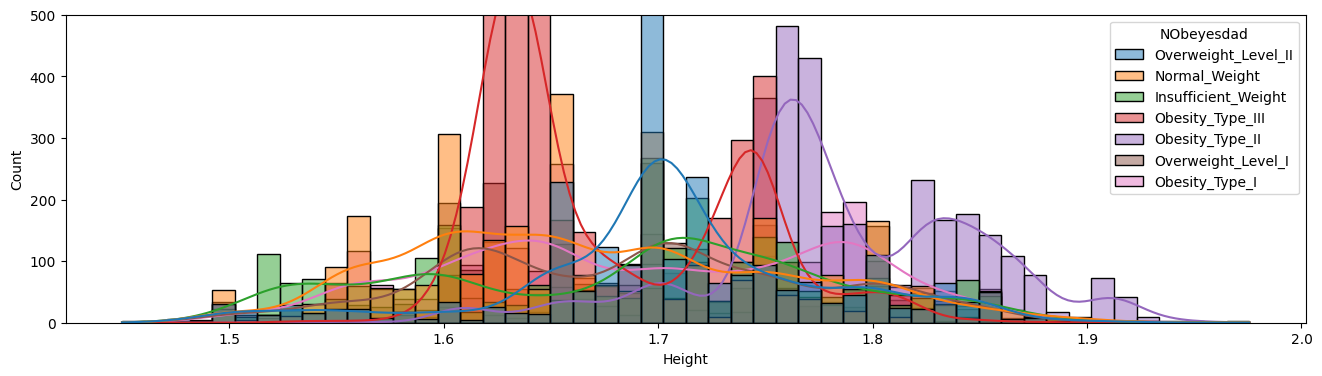

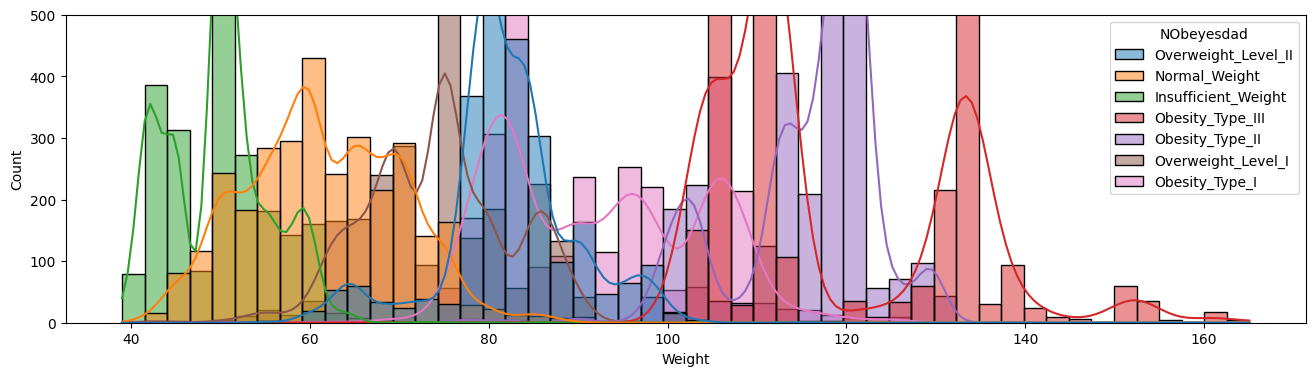

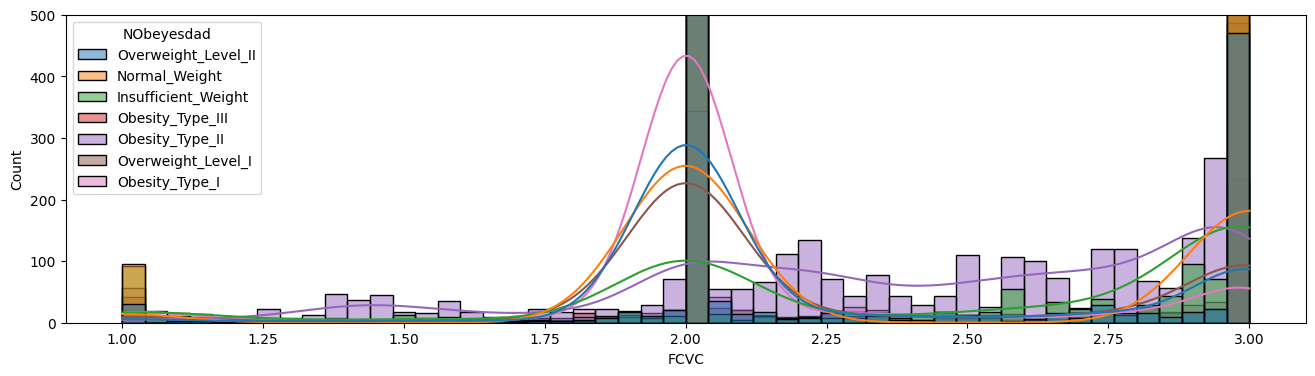

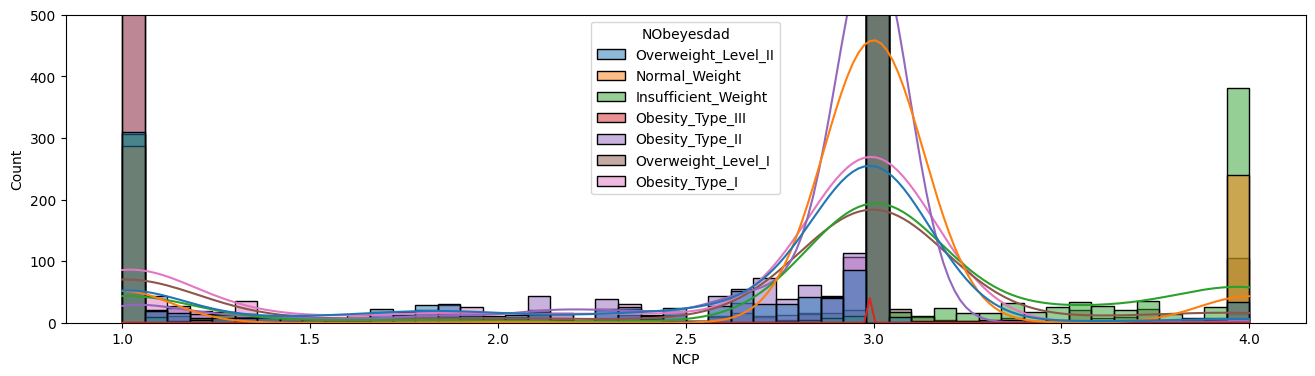

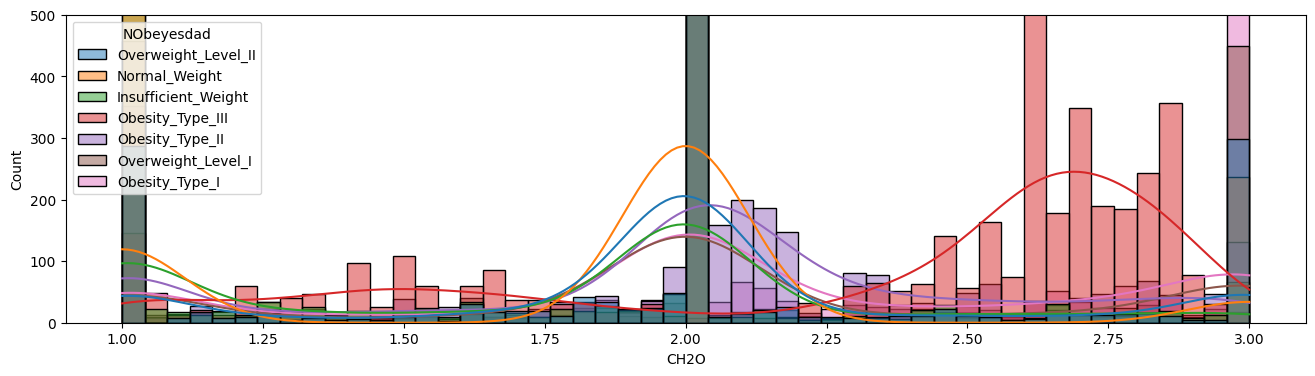

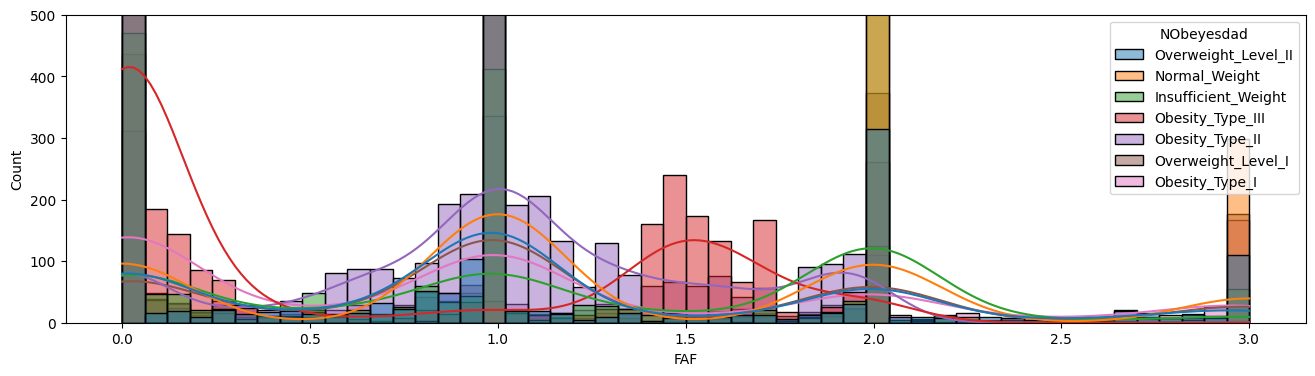

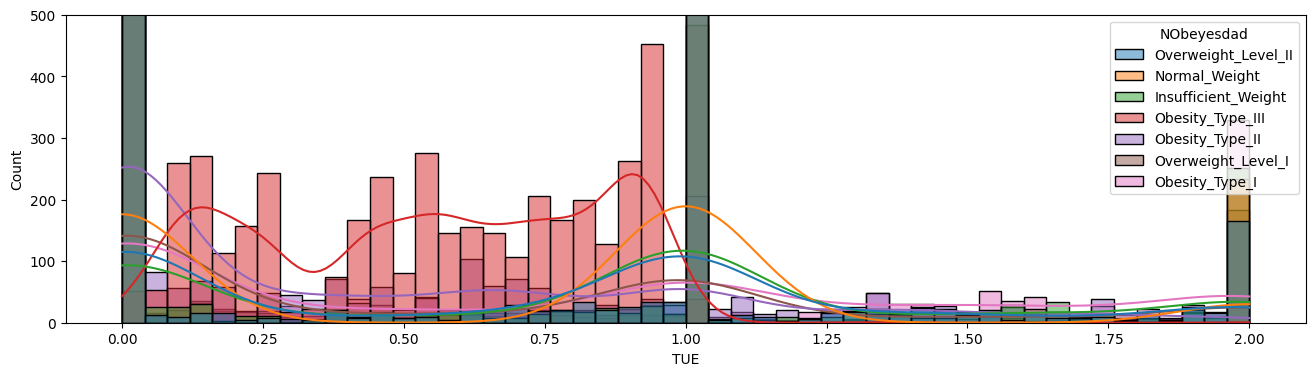

In [13]:
# plot the histograms of the continuous columns
continuous_vars = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"] # Add your list of columns here
# plot the histograms of the continuous columns
for column in continuous_vars:
    plot_histograms_and_density(df_train, column)

In [14]:
df_train = pd.concat([df_train, original_data]).drop_duplicates()

In [15]:
categorical_vars.remove('NObeyesdad')

In [16]:
# Convert categorical variable into dummy/indicator variables. | one-hot encoding
df_train = pd.get_dummies(df_train, columns=categorical_vars)
df_test = pd.get_dummies(df_test, columns=categorical_vars)
df_train.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Female,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,False,...,False,False,False,True,False,False,False,False,True,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,True,...,False,False,False,False,True,True,False,False,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,True,...,False,False,False,False,True,False,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,True,...,False,False,False,True,False,False,False,False,True,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,False,...,False,False,False,True,False,False,False,False,True,False


In [17]:
df_test.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
id,,,,,,,,,,,,,,,,,,,,,
20758,26.899886,1.848294,120.644178,2.938616,3.000000,2.825629,0.855400,0.000000,False,True,...,False,False,False,True,False,False,False,False,True,False
20759,21.000000,1.600000,66.000000,2.000000,1.000000,3.000000,1.000000,0.000000,True,False,...,False,False,False,True,False,False,False,False,True,False
20760,26.000000,1.643355,111.600553,3.000000,3.000000,2.621877,0.000000,0.250502,True,False,...,False,False,False,True,False,False,False,False,True,False
20761,20.979254,1.553127,103.669116,2.000000,2.977909,2.786417,0.094851,0.000000,False,True,...,False,False,False,True,False,False,False,False,True,False
20762,26.000000,1.627396,104.835346,3.000000,3.000000,2.653531,0.000000,0.741069,True,False,...,False,False,False,True,False,False,False,False,True,False


In [18]:
# Get the data set ready
X = df_train.drop(['NObeyesdad'], axis=1)
y = df_train['NObeyesdad']
X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,False,True,...,False,False,False,True,False,False,False,False,True,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,True,False,...,False,False,False,False,True,True,False,False,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,True,False,...,False,False,False,False,True,False,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,True,False,...,False,False,False,True,False,False,False,False,True,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,False,True,...,False,False,False,True,False,False,False,False,True,False


In [29]:
y.head()

,NObeyesdad
0,Overweight_Level_II
1,Normal_Weight
2,Insufficient_Weight
3,Obesity_Type_III
4,Overweight_Level_II


In [32]:
# Split the training data into train and test sets
!pip install scikit-learn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Print the shapes of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18276, 31)
X_test shape: (4569, 31)
y_train shape: (18276,)
y_test shape: (4569,)


In [34]:
print(X_train)

             Age    Height      Weight      FCVC       NCP      CH2O  \
7466   22.000000  1.700000   50.000000  1.000000  3.000000  2.000000   
8528   20.801791  1.738717  131.042274  3.000000  3.000000  1.837184   
3481   21.000000  1.540000   50.000000  3.000000  3.000000  3.000000   
1339   23.000000  1.799406  106.528811  2.123159  3.000000  2.415343   
1357   26.000000  1.602025  110.818757  3.000000  3.000000  2.825629   
...          ...       ...         ...       ...       ...       ...   
11964  22.000000  1.750000   95.000000  3.000000  3.000000  2.000000   
838    26.000000  1.745033   80.000000  2.217267  1.193589  2.000000   
5390   21.000000  1.620000   68.000000  2.000000  3.000000  3.000000   
860    26.000000  1.650125  111.939671  3.000000  3.000000  2.770732   
15795  37.997912  1.774330  107.998815  2.964419  2.902766  2.745242   

            FAF       TUE  Gender_Female  Gender_Male  ...  SCC_yes  \
7466   0.000000  2.000000           True        False  ...    Fa

In [35]:
!pip install pandas
import pandas as pd
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [36]:
params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.03,  # Learning rate for gradient boosting
    'n_estimators': 500,                # Number of boosting iterations
    'lambda_l1': 0.0097,  # L1 regularization term
    'lambda_l2': 0.04,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.41,  # Fraction of features to consider for each tree
    'subsample': 0.95,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

In [37]:
lgbm_classifier = LGBMClassifier(**params)

lgbm_classifier.fit(X_train, y_train)

y_pred = lgbm_classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9142044210987087

In [39]:
predictions = lgbm_classifier.predict(X_test)
predictions

array(['Obesity_Type_III', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Overweight_Level_II', 'Obesity_Type_II', 'Obesity_Type_II'],
      dtype=object)

In [40]:
sample_submission = pd.read_csv('sample_submission.csv')

sample_submission


,id,NObeyesdad
0,20758,Normal_Weight
1,20759,Normal_Weight
2,20760,Normal_Weight
3,20761,Normal_Weight
4,20762,Normal_Weight
...,...,...
13835,34593,Normal_Weight
13836,34594,Normal_Weight
13837,34595,Normal_Weight
13838,34596,Normal_Weight


In [28]:
#Check the shapes of both objects to ensure they are compatible
print(f"Shape of predictions: {predictions.shape}")
print(f"Shape of sample_submission: {sample_submission.shape}")


Shape of predictions: (4569,)
Shape of sample_submission: (13840, 2)
